# This program will create a facet grid (a.k.a., sorted distribution charts for all teams) for a specific league in a specific season.
### Make sure to run the match log download program for the league you want to visualize first!

C:\Users\Ben\AppData\Local\Temp/ipykernel_24336/2241069530.py:41: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mu = float(a.mean())
C:\Users\Ben\AppData\Local\Temp/ipykernel_24336/2241069530.py:42: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  med = float(a.median())
C:\Users\Ben\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


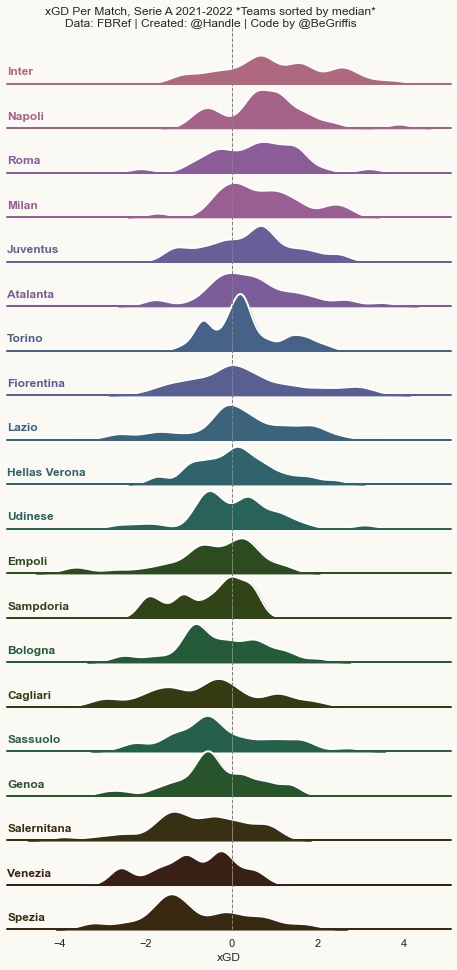

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# this is the file path root, i.e. where this file is located
root = str(Path(os.getcwd()).parents[0]).replace('\\','/')+'/'

############### Enter the desired info here ###############
var = 'xGD'            # Variable you want to plot distributions for
num_teams = 20         # Number of teams in the league
league = 'Serie A'     # League you want to use
signature = '@Handle'  # Your handle
ssn = '2021-2022'      # Season you want to plot 
num_matches = ''       # If you want to only look at the first X matches, enter that here. otherwise, leave blank
save = 'n'             # 'y' to save the figure

df1 = pd.read_csv("%s%s Match Log.csv" %(root,league))
if num_matches != '':
    df1 = df1[df1['Match Number']<=int(num_matches)]
df1 = df1[df1['Season']==ssn]

# Create the data
x = df1['%s' %var]
g = list(df1.Team)
df = pd.DataFrame(dict(x=x, g=g))

# create the sort by median and then mean (in case of 2 medians being equal) of variable
team_unique = list(df.g.unique())
means_ = range(0,num_teams)
meds_ = range(0,num_teams)
d = {'g': team_unique, 'Mean': means_, 'Median': meds_}
df_means = pd.DataFrame(data=d)

for i in range(len(team_unique)):
    a = df[df['g']==team_unique[i]]
    mu = float(a.mean())
    med = float(a.median())
    df_means['g'].iloc[i] = team_unique[i]
    df_means['Mean'].iloc[i] = mu
    df_means['Median'].iloc[i] = med
df_means = df_means.sort_values(by=['Median', 'Mean'], ascending=[False,False])
y_order = list(df_means['g'])

df = df.merge(df_means, on='g', how='left')
df = df.sort_values(by='Mean', ascending=False)

# Initialize the FacetGrid
pal = sns.cubehelix_palette(num_teams, rot=2.5, light=.5)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, row_order=y_order, palette=pal)

# Draw the distributions
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.refline(x=0, linewidth=1, linestyle="--", color='grey', clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='%s' %var)
g.despine(bottom=True, left=True)
fig = plt.gcf()
fig.patch.set_facecolor('#fbf9f4')
fig.set_size_inches(7, 14)

if num_matches == '':
    matches = ''
else:
    matches = ' (after %s matches)' %num_matches
fig.suptitle('%s Per Match, %s %s%s *Teams sorted by median*\nData: FBRef | Created: %s | Code by @BeGriffis'
             %(var,league,ssn,matches,signature),
             fontsize=12)

if save == 'y':
    fig.savefig("%s%s %s Facet Grid %s.png" %(root,league,var,ssn), dpi=220)
